# Simulation of Vessel Trajectories & Anomalies

In [503]:
import logging
from datetime import datetime, timedelta
import json

from model import ShipModel
from agents.ship import Ship

logging.basicConfig(
    filename="notebook_logs.log",
    filemode="w",  # Overwrites on each run; use "a" to append
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

config_file="config/config.json"
with open(config_file) as f:
    config = json.load(f)

steps = config["simulation_steps"]
    
model = ShipModel(
        width=config["width"],
        height=config["height"],
        num_ships=config["num_ships"],
        max_speed_range=config["max_speed_range"],
        ports=config["ports"],
        speed_limit_zones=config.get("speed_limit_zones", []),
        obstacles=config["obstacles"],
        dwa_config=config["dwa_config"],
        resolution=config["resolution"],
        obstacle_threshold=config["obstacle_threshold"],
        lookahead=config["lookahead"]
    )

for type, agents in model.agents_by_type.items():
    print(f'{type}: {len(agents)}')

for ship in model.agents.select(agent_type=Ship):
    print(f"Ship {ship.unique_id} has a maximum speed of {ship.original_max_speed}.")

<class 'agents.obstacle.Obstacle'>: 8
<class 'agents.port.Port'>: 10
<class 'agents.ship.Ship'>: 20
Ship 19 has a maximum speed of 1.3660182473213263.
Ship 20 has a maximum speed of 1.0762008101814988.
Ship 21 has a maximum speed of 1.3405945059290199.
Ship 22 has a maximum speed of 1.4770991316634714.
Ship 23 has a maximum speed of 1.1574770600161175.
Ship 24 has a maximum speed of 1.3426648853329328.
Ship 25 has a maximum speed of 1.0160485784607305.
Ship 26 has a maximum speed of 1.373133725974773.
Ship 27 has a maximum speed of 1.4881869784879347.
Ship 28 has a maximum speed of 1.154063417360605.
Ship 29 has a maximum speed of 1.4189936655905404.
Ship 30 has a maximum speed of 1.432919410488017.
Ship 31 has a maximum speed of 1.2650300105037662.
Ship 32 has a maximum speed of 1.0890200153564362.
Ship 33 has a maximum speed of 1.366448286893431.
Ship 34 has a maximum speed of 1.3471980261349503.
Ship 35 has a maximum speed of 1.4616963226397146.
Ship 36 has a maximum speed of 1.2180

## Trajectory Simulation

In [504]:
print(f"{datetime.now()} Starting ...")
for t in range(steps):
    stride = 50
    if t%stride == 0:
        print(f"Steps {t} - {t+stride-1}...")
    model.step()
print(f"{datetime.now()} Finished.")

2025-03-20 18:04:58.320046 Starting ...
Steps 0 - 49...
Steps 50 - 99...
Steps 100 - 149...
Steps 150 - 199...
Steps 200 - 249...
Steps 250 - 299...
Steps 300 - 349...
Steps 350 - 399...
Steps 400 - 449...
Steps 450 - 499...
Steps 500 - 549...
Steps 550 - 599...
Steps 600 - 649...
Steps 650 - 699...
Steps 700 - 749...
Steps 750 - 799...
Steps 800 - 849...
Steps 850 - 899...
Steps 900 - 949...
Steps 950 - 999...
2025-03-20 18:09:18.092364 Finished.


In [505]:
agent_df = model.datacollector.get_agent_vars_dataframe().dropna()
df = agent_df.reset_index()
df

,Step,AgentID,x,y,AStarPath
0,0,19,30.000000,50.000000,"[(30.5, 50.5), (31.5, 50.5), (32.5, 50.5), (33..."
1,0,20,15.000000,45.000000,"[(15.5, 45.5), (15.5, 46.5), (14.5, 47.5), (13..."
2,0,21,15.000000,45.000000,"[(15.5, 45.5), (15.5, 44.5), (15.5, 43.5), (15..."
3,0,22,99.000000,35.000000,"[(99.5, 35.5), (99.5, 34.5), (99.5, 33.5), (99..."
4,0,23,15.000000,45.000000,"[(15.5, 45.5), (16.5, 45.5), (17.5, 45.5), (18..."
...,...,...,...,...,...
20015,1000,28,27.228771,40.003969,"[(55.5, 85.5), (54.5, 84.5), (53.5, 83.5), (52..."
20016,1000,23,38.528633,66.550555,"[(15.5, 45.5), (16.5, 45.5), (17.5, 45.5), (18..."
20017,1000,24,45.000000,20.000000,"[(90.5, 10.5), (89.5, 10.5), (88.5, 10.5), (87..."
20018,1000,30,90.000000,10.000000,"[(70.5, 60.5), (70.5, 59.5), (70.5, 58.5), (70..."


Saved simulation plot to simulation_plot.png


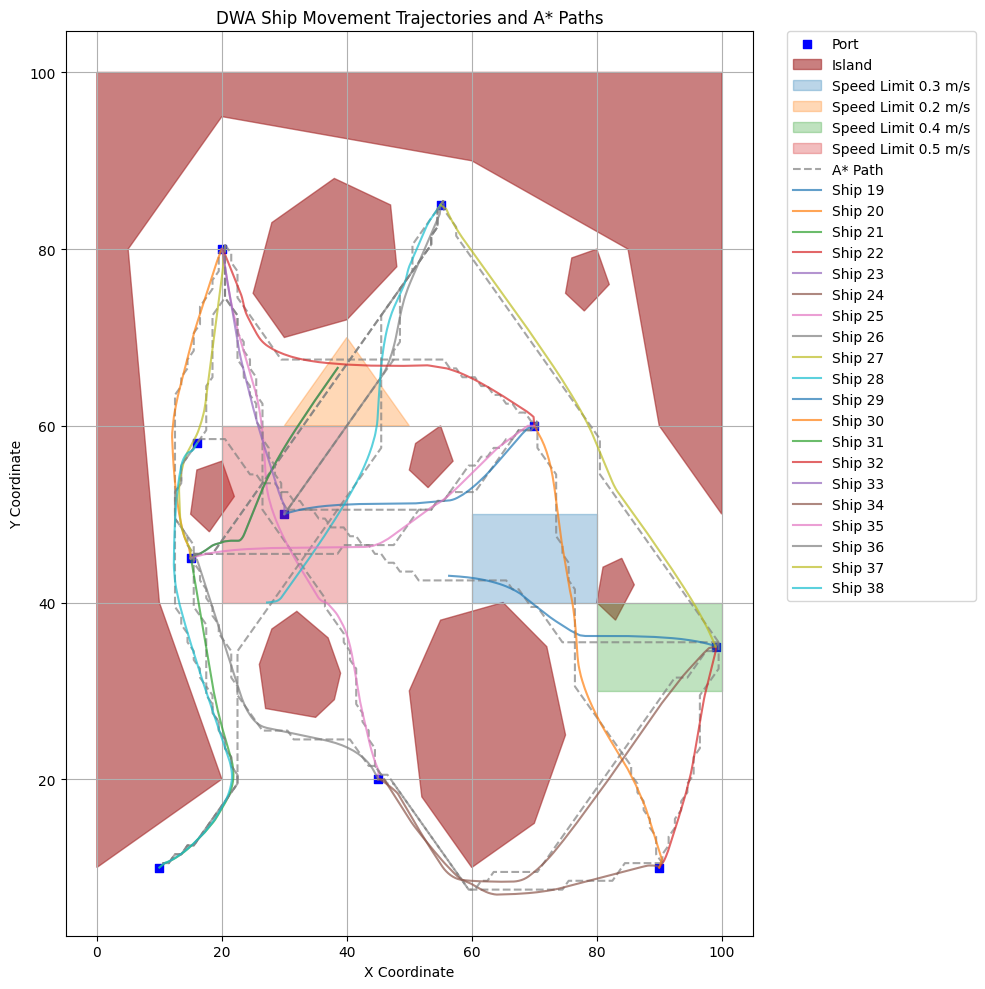

In [506]:
from visualization import plot_simulation

# Run visualization
plot_simulation(df, config)

In [507]:
import movingpandas as mpd

start_datetime = datetime.now()
df["t"] = df["Step"].apply(lambda step: start_datetime + timedelta(seconds=step))
tc = mpd.TrajectoryCollection(df, traj_id_col='AgentID', t='t', x='x', y='y', crs=31287)

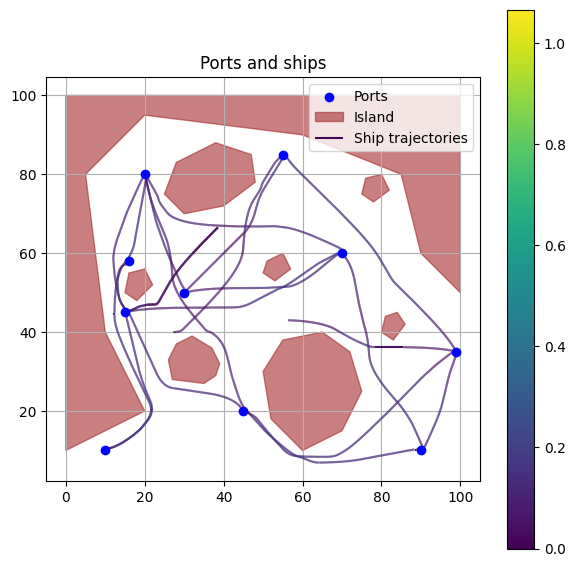

In [508]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

fig, ax = plt.subplots(figsize=(7,7))

x_coords, y_coords = zip(*config["ports"])
ax.scatter(x_coords, y_coords, color='blue', label='Ports', zorder=5)

for island in config["obstacles"]:
    island_shape = Polygon(island)
    x, y = island_shape.exterior.xy
    ax.fill(x, y, color="brown", alpha=0.6, label="Island" if 'Island' not in plt.gca().get_legend_handles_labels()[1] else "")

tc.plot(ax=ax, label='Ship trajectories', column='speed', legend=True)
ax.grid(True)

# Labels and legend
ax.legend()
ax.set_title("Ports and ships")

plt.show()

In [509]:
tc.trajectories[0].hvplot()

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Path.I   :Path   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (triangle_angle)

In [510]:
tc.add_speed(overwrite=True)
tc.trajectories[0].df#.hvplot(c='speed')

,Step,AgentID,AStarPath,geometry,speed
t,,,,,
2025-03-20 18:09:18.667634,0,19,"[(30.5, 50.5), (31.5, 50.5), (32.5, 50.5), (33...",POINT (30 50),0.010
2025-03-20 18:09:19.667634,1,19,"[(30.5, 50.5), (31.5, 50.5), (32.5, 50.5), (33...",POINT (30.009 50.003),0.010
2025-03-20 18:09:20.667634,2,19,"[(30.5, 50.5), (31.5, 50.5), (32.5, 50.5), (33...",POINT (30.02 50.006),0.011
2025-03-20 18:09:21.667634,3,19,"[(30.5, 50.5), (31.5, 50.5), (32.5, 50.5), (33...",POINT (30.032 50.01),0.012
2025-03-20 18:09:22.667634,4,19,"[(30.5, 50.5), (31.5, 50.5), (32.5, 50.5), (33...",POINT (30.044 50.013),0.013
...,...,...,...,...,...
2025-03-20 18:25:54.667634,996,19,"[(30.5, 50.5), (31.5, 50.5), (32.5, 50.5), (33...",POINT (70 60),0.000
2025-03-20 18:25:55.667634,997,19,"[(30.5, 50.5), (31.5, 50.5), (32.5, 50.5), (33...",POINT (70 60),0.000
2025-03-20 18:25:56.667634,998,19,"[(30.5, 50.5), (31.5, 50.5), (32.5, 50.5), (33...",POINT (70 60),0.000


In [511]:
sim_result = tc.to_point_gdf()
sim_result['x'] = sim_result.geometry.x
sim_result['y'] = sim_result.geometry.y
sim_result = sim_result.drop('AStarPath', axis=1)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
sim_out_file_name = f'sim_{timestamp}.csv'
sim_result.to_csv(sim_out_file_name)
print(f'Saved simulation results to {sim_out_file_name}')

Saved simulation results to sim_20250320_180922.csv


### Anomaly Simulation

In [512]:
import numpy as np
import pandas as pd
import movingpandas as mpd
from datetime import datetime, timedelta

In [513]:
# sim_out_file_name = 'sim_20250320_122642.csv'

In [514]:
# sims = pd.read_csv(sim_out_file_name)
sims = sim_result
sims['is_anomaly'] = False
sims['anomaly_type'] = 'n/a'
tc = mpd.TrajectoryCollection(sims, t='t', traj_id_col='AgentID', x='x', y='y', crs=31287)
tc

TrajectoryCollection with 20 trajectories

In [515]:
# Remove stopped segments (with speed < 0.01)
tc = mpd.SpeedSplitter(tc).split(speed=0.01, duration=timedelta(seconds=5))

### Speed

* Change the timestamps to make a subsection of the trajectory faster

In [516]:
def inject_speed_anomaly(traj, duration_pct=(0.1,0.2), speedup_pct=(1.5,2.5)):
    df = traj.df.copy()
    df.reset_index(inplace=True)
    df["t_diff"] = df['t'].diff()
    # Choose within middle range
    total_steps = len(df)
    anomaly_start_idx = np.random.randint(0.1 * total_steps, 0.8 * total_steps)  
    duration_pct = duration_pct[0] + (np.random.random() * (duration_pct[1]-duration_pct[0]))
    anomaly_duration = int(duration_pct * total_steps)  
    # Insert new values
    speedup_pct = speedup_pct[0] + (np.random.random() * (speedup_pct[1]-speedup_pct[0]))
    new_vals = df.iloc[anomaly_start_idx : anomaly_start_idx + anomaly_duration].t_diff / speedup_pct
    df.loc[anomaly_start_idx : anomaly_start_idx + anomaly_duration -1, "t_diff"] = new_vals
    # Flag anomalies
    df.loc[anomaly_start_idx : anomaly_start_idx + anomaly_duration -1, "is_anomaly"] = True
    df.loc[anomaly_start_idx : anomaly_start_idx + anomaly_duration -1, "anomaly_type"] = 'speed'

    # Correct the timestamp update logic
    df["t"] = df["t"].iloc[0] + df["t_diff"].fillna(pd.Timedelta(seconds=0)).cumsum()
    return mpd.Trajectory(df,t='t',traj_id=traj.id)

<Axes: >

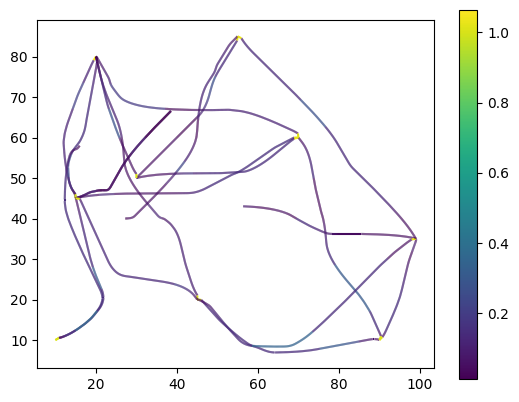

In [517]:
for i, traj in enumerate(tc.trajectories):
    traj = inject_speed_anomaly(traj)
    tc.trajectories[i] = traj
    
tc.add_speed(overwrite=True)
tc.plot(column='speed', legend=True)

### Location

Select all trajectories that go through a certain area and mark them anomalous

<Axes: >

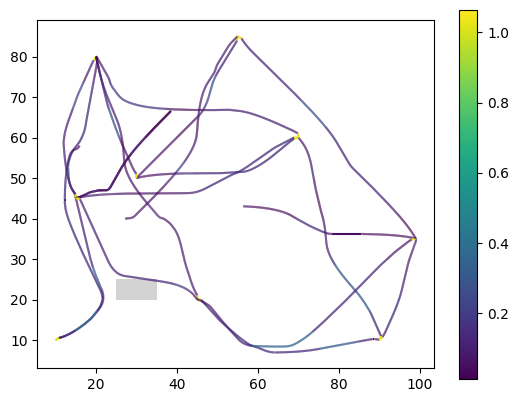

In [518]:
from shapely.geometry import Polygon
from geopandas import GeoSeries
xmin, xmax, ymin, ymax = 25, 35, 20, 25
polygon = Polygon([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin), (xmin, ymin)])

ax= tc.plot(column='speed', legend=True)
GeoSeries(polygon).plot(ax=ax, color="lightgray")

### Direction

* Pick an OD combination that will be marked as anomalous in one direction

In [519]:
tc = mpd.SpeedSplitter(tc).split(speed=1.0, duration=timedelta(seconds=5))
tc

TrajectoryCollection with 0 trajectories